In [1]:
import utils
import sys
if 'utils' in sys.modules:
    del sys.modules['utils']
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_path = 'weights/checkpoint_32x32.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = True
AUGMENT_FRACTION = 0.2
TRANSFORM_DATASET = False

COSINE_ANNEALING = True
STEPLR = False
REDUCE_ON_PLATEAU = False

OPTIMIZER='ADAM'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.0008
MOMENTUM = 0.9
EPOCHS = 30

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 3

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
train_dataset, train_dataset_raw = utils.create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET, AUGMENT_FRACTION)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000
Dimensione del sottoinsieme aumentato: 12000
Dimensione del dataset combinato: 72000


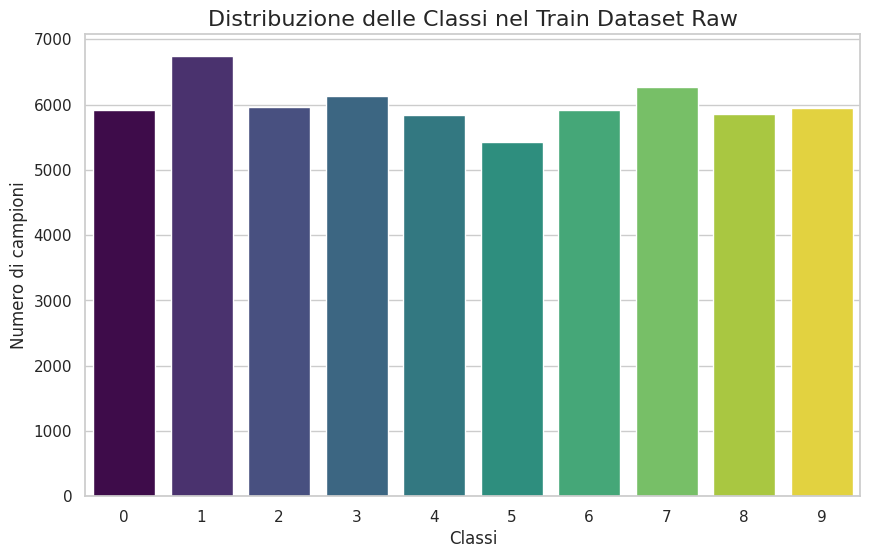

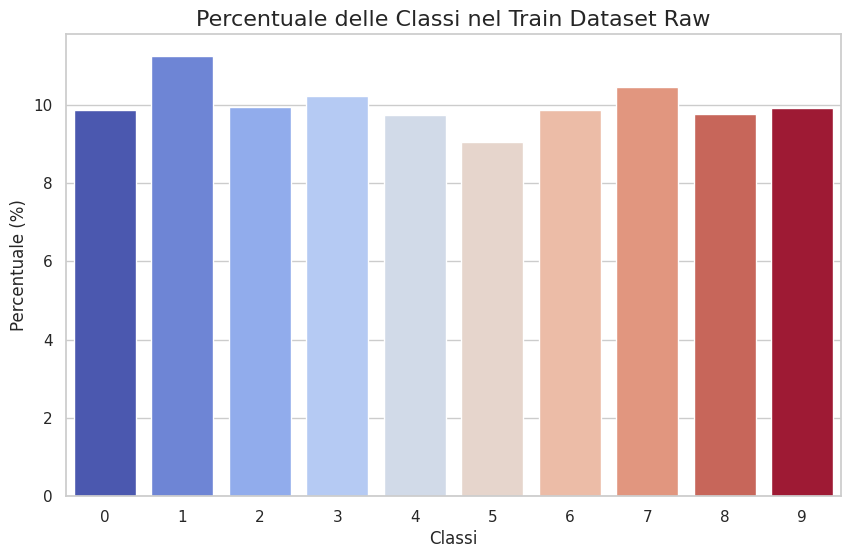

In [3]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 72000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 24025, 1: 23935, 2: 24040}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 24025 campioni (33.37%)
Relazione 1: 23935 campioni (33.24%)
Relazione 2: 24040 campioni (33.39%)




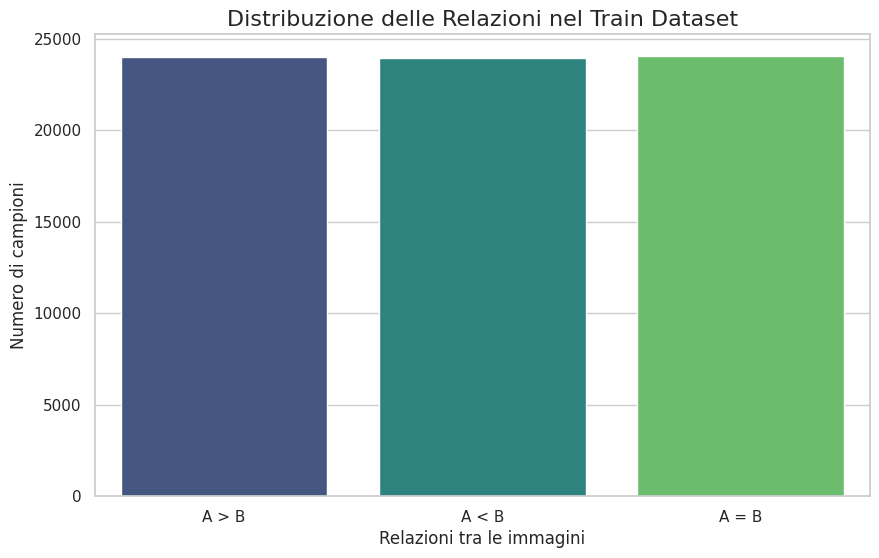

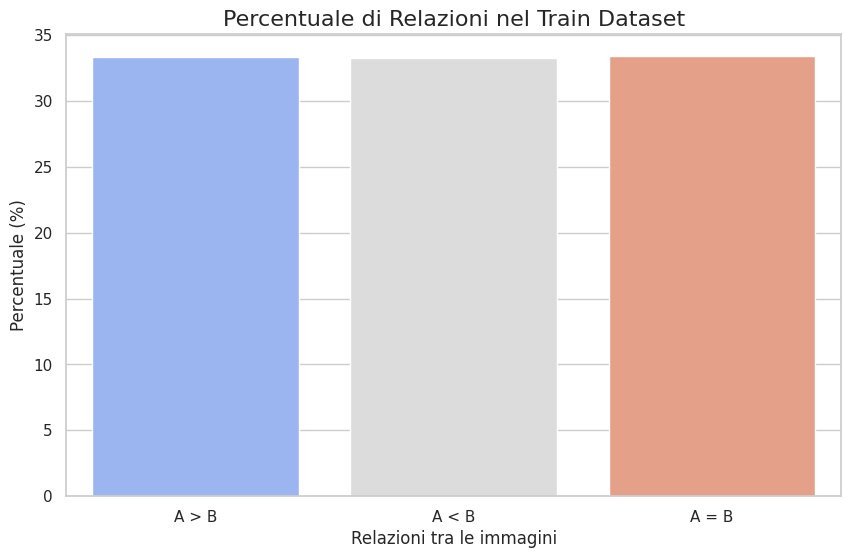

In [4]:
utils.plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 979, 0: 986, 1: 1035}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 2: 979 campioni (32.63%)
Relazione 0: 986 campioni (32.87%)
Relazione 1: 1035 campioni (34.50%)




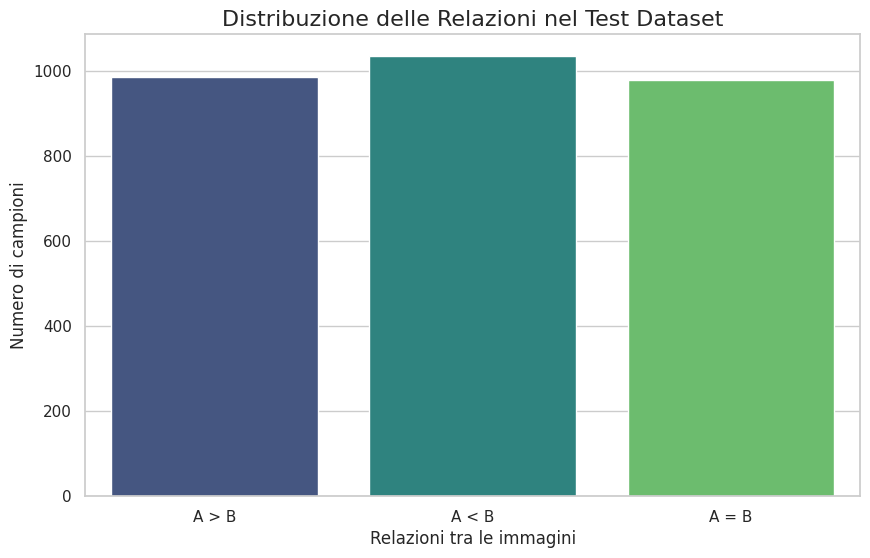

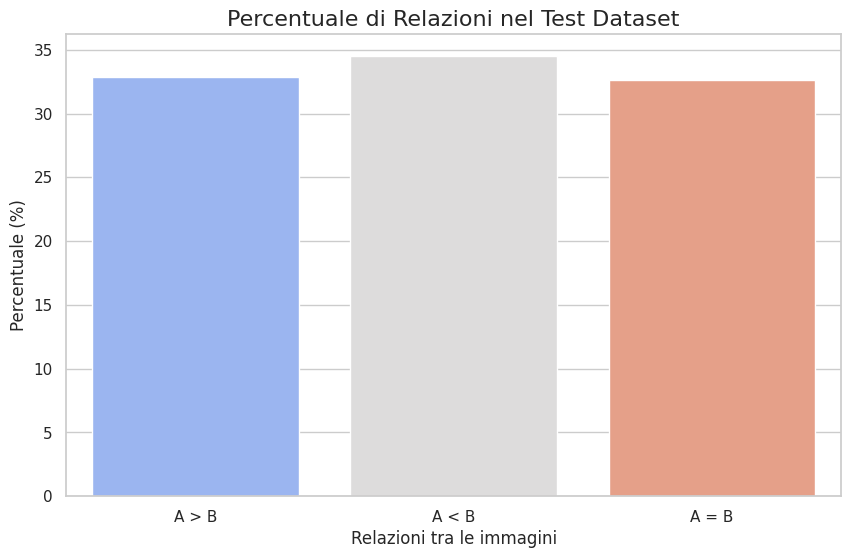

In [5]:
utils.plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2347, 1: 2298, 2: 2354}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2347 campioni (33.53%)
Relazione 1: 2298 campioni (32.83%)
Relazione 2: 2354 campioni (33.63%)




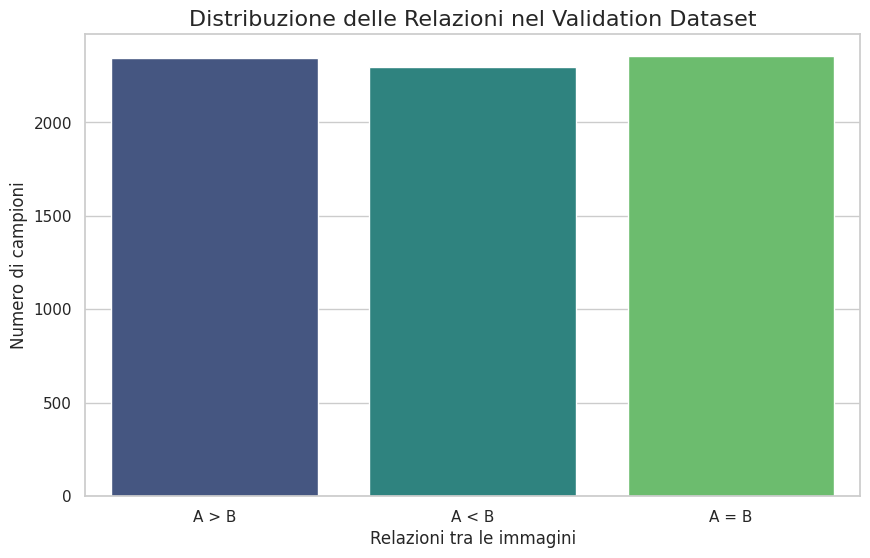

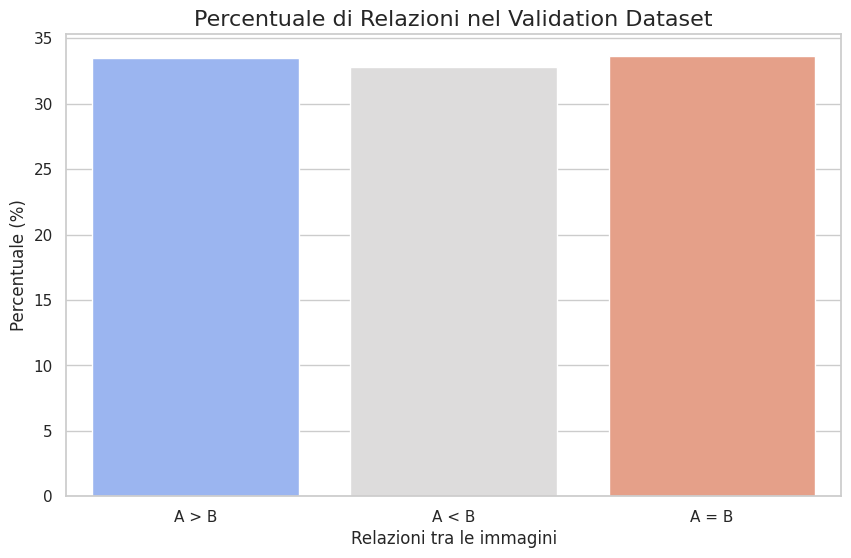

In [6]:
utils.plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [7]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [8]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  563  Size train_dataset:  72000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [11]:
# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

if REDUCE_ON_PLATEAU:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
elif COSINE_ANNEALING:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
elif STEPLR:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7, verbose=True)

images dtype: torch.float32, labels dtype: torch.int64


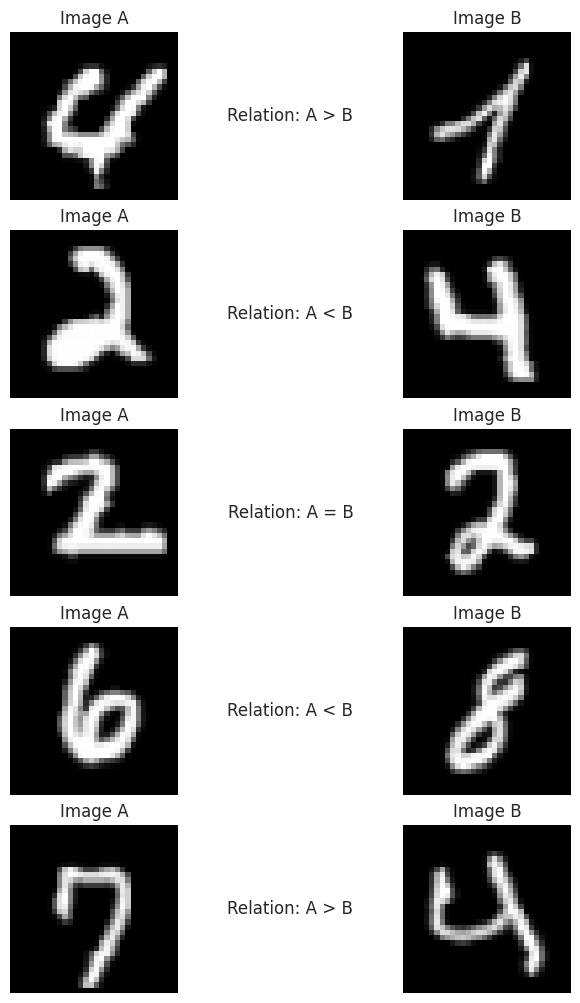

In [12]:

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', utils.show_dataset(train_loader, 5))

In [13]:
# Definisci le liste per salvare i valori di loss e accuracy

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # Inizializzazione della progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # Aggiorna il valore della loss nella progress bar per ogni iterazione
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [14]:
# TRAIN!!!
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        if REDUCE_ON_PLATEAU:
                scheduler.step(val_loss)
        else:
                scheduler.step()

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 30
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Loss: 0.5002: 100%|██████████| 563/563 [00:16<00:00, 34.91it/s]


Validating


Loss: 0.4984: 100%|██████████| 55/55 [00:00<00:00, 65.23it/s]


Epoch #1 train loss: 0.731 train accuracy: 66.89
Epoch #1 validation loss: 0.498 validation accuracy: 80.61
Learning rate actual:  0.0007978087581473094
Took 0.283 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 30
Training


Loss: 0.6452: 100%|██████████| 563/563 [00:15<00:00, 35.51it/s]


Validating


Loss: 0.3640: 100%|██████████| 55/55 [00:00<00:00, 70.08it/s]


Epoch #2 train loss: 0.493 train accuracy: 79.00
Epoch #2 validation loss: 0.364 validation accuracy: 87.53
Learning rate actual:  0.0007912590402935223
Took 0.278 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 30
Training


Loss: 0.3907: 100%|██████████| 563/563 [00:15<00:00, 37.45it/s]


Validating


Loss: 0.2982: 100%|██████████| 55/55 [00:00<00:00, 73.03it/s]


Epoch #3 train loss: 0.395 train accuracy: 83.61
Epoch #3 validation loss: 0.298 validation accuracy: 90.23
Learning rate actual:  0.0007804226065180615
Took 0.263 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 30
Training


Loss: 0.3008: 100%|██████████| 563/563 [00:15<00:00, 36.65it/s]


Validating


Loss: 0.2790: 100%|██████████| 55/55 [00:00<00:00, 61.27it/s]


Epoch #4 train loss: 0.337 train accuracy: 86.04
Epoch #4 validation loss: 0.279 validation accuracy: 91.34
Learning rate actual:  0.0007654181830570403
Took 0.271 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 30
Training


Loss: 0.3947: 100%|██████████| 563/563 [00:15<00:00, 36.67it/s]


Validating


Loss: 0.2166: 100%|██████████| 55/55 [00:00<00:00, 71.09it/s]


Epoch #5 train loss: 0.295 train accuracy: 87.90
Epoch #5 validation loss: 0.217 validation accuracy: 92.84
Learning rate actual:  0.0007464101615137755
Took 0.269 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 30
Training


Loss: 0.2639: 100%|██████████| 563/563 [00:15<00:00, 36.92it/s]


Validating


Loss: 0.2214: 100%|██████████| 55/55 [00:00<00:00, 70.97it/s]


Epoch #6 train loss: 0.261 train accuracy: 89.25
Epoch #6 validation loss: 0.221 validation accuracy: 93.67
Learning rate actual:  0.000723606797749979
Took 0.267 minutes for epoch 6
No improvement for 1 epoch(s).
Checkpoint saved at epoch 6.

EPOCH 7 of 30
Training


Loss: 0.1619: 100%|██████████| 563/563 [00:14<00:00, 38.63it/s]


Validating


Loss: 0.1800: 100%|██████████| 55/55 [00:00<00:00, 74.65it/s]


Epoch #7 train loss: 0.234 train accuracy: 90.37
Epoch #7 validation loss: 0.180 validation accuracy: 93.54
Learning rate actual:  0.0006972579301909577
Took 0.255 minutes for epoch 7
Checkpoint saved at epoch 7.

EPOCH 8 of 30
Training


Loss: 0.2183: 100%|██████████| 563/563 [00:14<00:00, 38.56it/s]


Validating


Loss: 0.2173: 100%|██████████| 55/55 [00:00<00:00, 69.15it/s]


Epoch #8 train loss: 0.212 train accuracy: 91.52
Epoch #8 validation loss: 0.217 validation accuracy: 93.76
Learning rate actual:  0.0006676522425435433
Took 0.257 minutes for epoch 8
No improvement for 1 epoch(s).
Checkpoint saved at epoch 8.

EPOCH 9 of 30
Training


Loss: 0.1294: 100%|██████████| 563/563 [00:15<00:00, 36.73it/s]


Validating


Loss: 0.2378: 100%|██████████| 55/55 [00:00<00:00, 68.68it/s]


Epoch #9 train loss: 0.191 train accuracy: 92.25
Epoch #9 validation loss: 0.238 validation accuracy: 93.36
Learning rate actual:  0.0006351141009169893
Took 0.269 minutes for epoch 9
No improvement for 2 epoch(s).
Checkpoint saved at epoch 9.

EPOCH 10 of 30
Training


Loss: 0.1546: 100%|██████████| 563/563 [00:15<00:00, 36.32it/s]


Validating


Loss: 0.1702: 100%|██████████| 55/55 [00:00<00:00, 72.15it/s]


Epoch #10 train loss: 0.175 train accuracy: 92.94
Epoch #10 validation loss: 0.170 validation accuracy: 93.86
Learning rate actual:  0.0006000000000000001
Took 0.271 minutes for epoch 10
Checkpoint saved at epoch 10.

EPOCH 11 of 30
Training


Loss: 0.1209: 100%|██████████| 563/563 [00:15<00:00, 36.42it/s]


Validating


Loss: 0.3600: 100%|██████████| 55/55 [00:00<00:00, 78.43it/s]


Epoch #11 train loss: 0.158 train accuracy: 93.70
Epoch #11 validation loss: 0.360 validation accuracy: 94.37
Learning rate actual:  0.0005626946572303203
Took 0.269 minutes for epoch 11
No improvement for 1 epoch(s).
Checkpoint saved at epoch 11.

EPOCH 12 of 30
Training


Loss: 0.1362: 100%|██████████| 563/563 [00:15<00:00, 36.20it/s]


Validating


Loss: 0.1694: 100%|██████████| 55/55 [00:00<00:00, 80.37it/s]


Epoch #12 train loss: 0.146 train accuracy: 94.19
Epoch #12 validation loss: 0.169 validation accuracy: 94.50
Learning rate actual:  0.0005236067977499791
Took 0.271 minutes for epoch 12
Checkpoint saved at epoch 12.

EPOCH 13 of 30
Training


Loss: 0.1382: 100%|██████████| 563/563 [00:15<00:00, 36.47it/s]


Validating


Loss: 0.2458: 100%|██████████| 55/55 [00:00<00:00, 81.15it/s]


Epoch #13 train loss: 0.130 train accuracy: 94.82
Epoch #13 validation loss: 0.246 validation accuracy: 94.01
Learning rate actual:  0.00048316467632710376
Took 0.269 minutes for epoch 13
No improvement for 1 epoch(s).
Checkpoint saved at epoch 13.

EPOCH 14 of 30
Training


Loss: 0.0688: 100%|██████████| 563/563 [00:14<00:00, 38.56it/s]


Validating


Loss: 0.2359: 100%|██████████| 55/55 [00:00<00:00, 83.24it/s]


Epoch #14 train loss: 0.116 train accuracy: 95.43
Epoch #14 validation loss: 0.236 validation accuracy: 94.16
Learning rate actual:  0.0004418113853070615
Took 0.254 minutes for epoch 14
No improvement for 2 epoch(s).
Checkpoint saved at epoch 14.

EPOCH 15 of 30
Training


Loss: 0.1520: 100%|██████████| 563/563 [00:14<00:00, 37.72it/s]


Validating


Loss: 0.2445: 100%|██████████| 55/55 [00:00<00:00, 77.64it/s]


Epoch #15 train loss: 0.103 train accuracy: 95.98
Epoch #15 validation loss: 0.245 validation accuracy: 94.70
Learning rate actual:  0.0004000000000000002
Took 0.261 minutes for epoch 15
No improvement for 3 epoch(s).
Early stopping triggered after 15 epochs.
Checkpoint saved at epoch 15.
Validating


Loss: 0.2503: 100%|██████████| 24/24 [00:00<00:00, 59.18it/s]

Test loss: 0.250 Test accuracy: 95.13


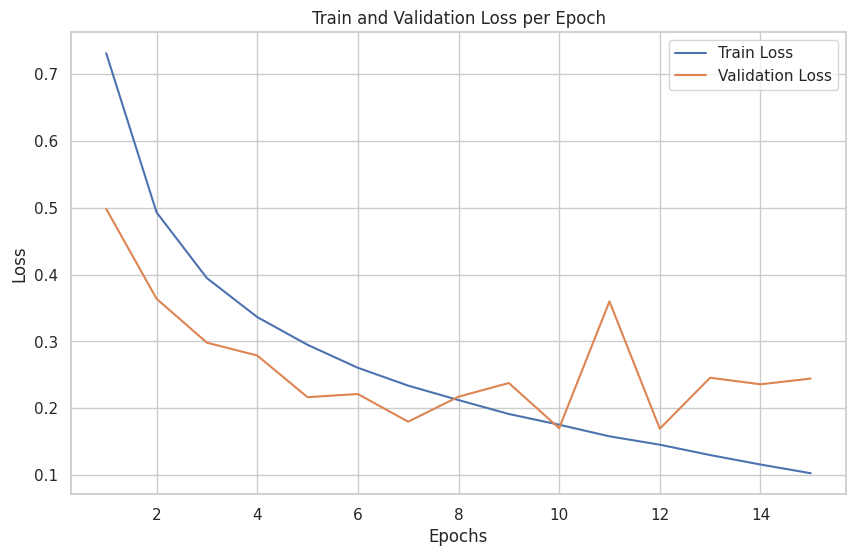

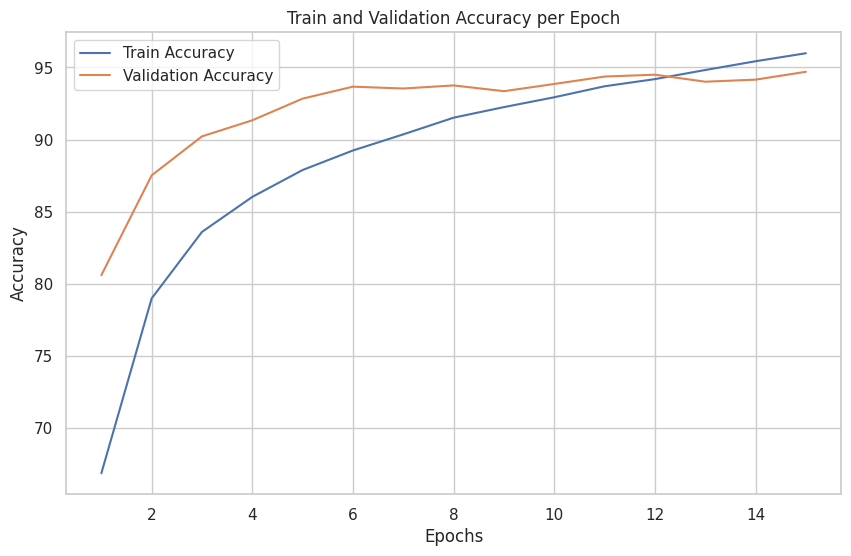

In [15]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

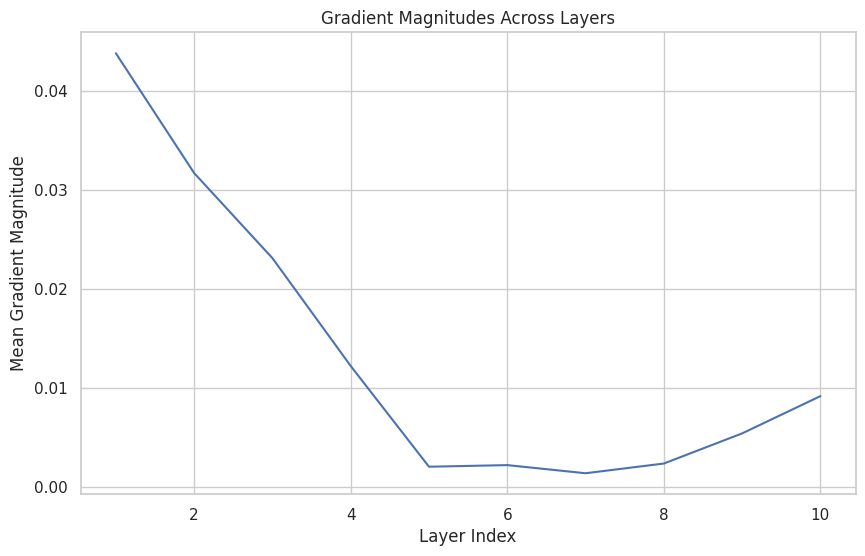

In [16]:
utils.plot_gradient(model)

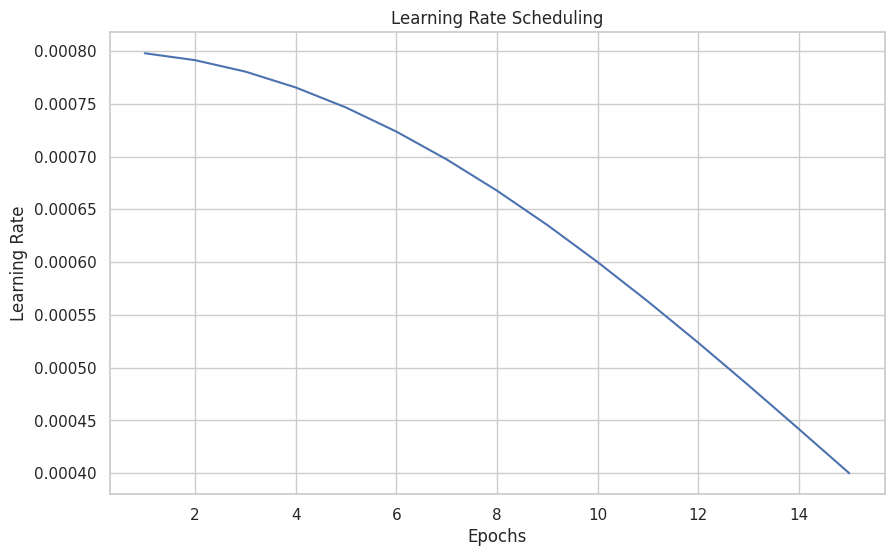

In [17]:
utils.plot_lr_scheduler(lr_history)

In [18]:
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val = utils.inference(model, validation_loader, device)
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test = utils.inference(model, test_loader, device)

371 previsioni errate trovate.


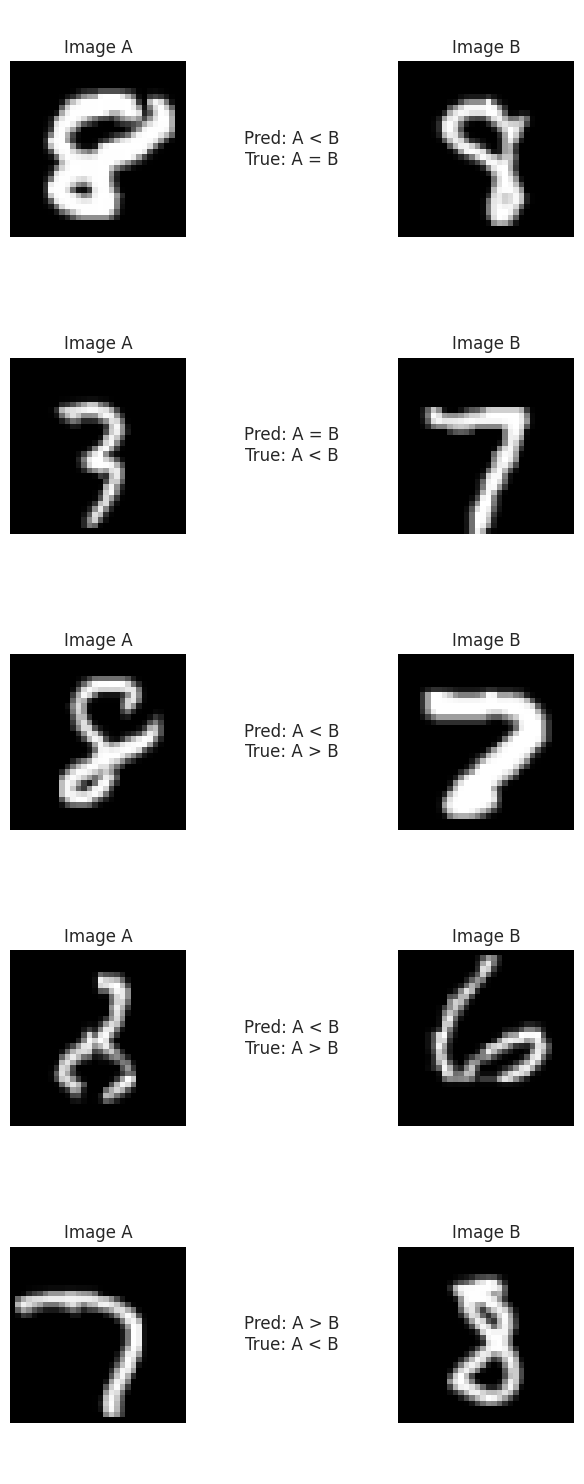

In [19]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_validation', utils.show_incorrect_predictions(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, num_images=5))

In [ ]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, num_images=5))

146 previsioni errate trovate.


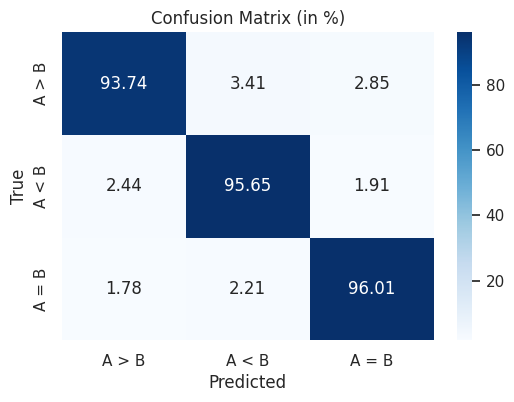

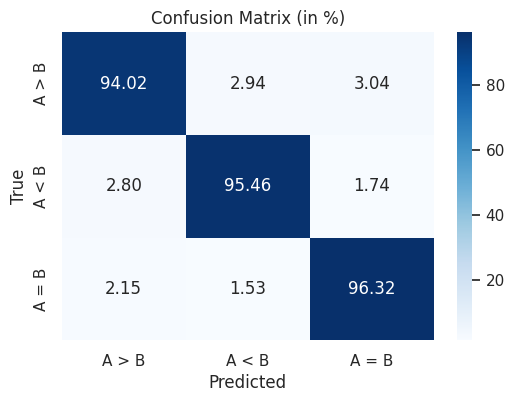

: 

: 

: 

: 

: 

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))
#plot_confusion_matrix(model, test_loader, device)


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)

              precision    recall  f1-score   support

       A > B       0.95      0.94      0.94       986
       A < B       0.96      0.95      0.96      1035
       A = B       0.95      0.96      0.96       979

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



: 

: 

: 

: 

: 

Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome base del nuovo notebook
    if OPTIMIZER == 'SGD':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    elif OPTIMIZER == 'ADAM':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    else:
        base_name = "run32x32"

    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")


# Specifica il nome del notebook attuale
save_notebook_copy('main_32x32.ipynb')


Notebook saved as run32x32_BS=128_LR=0.001_EPOCHS=30_AUG=True_TRA=False_OPT=ADAM.ipynb


: 

: 

: 

: 

: 

In [ ]:
writer.close()

: 

: 

: 

: 

: 